In [2]:
import GEOparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns    
import scipy                                     


In [3]:
gse = GEOparse.get_GEO("GSE4271", destdir="data/",silent=True)

In [4]:
expression_df = gse.pivot_samples('VALUE') # Some values in the thousands, apply log2 transformation
expression_df = np.log2(expression_df + 1.0)


meta = []
for gsm_name, gsm in gse.gsms.items():
    characteristics = gsm.metadata.get('characteristics_ch1', [])
    char_dict = {}
    for entry in characteristics:
        if ":" in entry:
            key, value = entry.split(":", 1)
            char_dict[key.strip()] = value.strip()   
    char_dict["sample"] = gsm_name
    char_dict["title"] = gsm.metadata.get("title", [""])[0]
    char_dict["source_name"] = gsm.metadata.get("source_name_ch1", [""])[0]
    meta.append(char_dict)
    
    
meta_df = pd.DataFrame(meta).set_index('sample')

# Getting indexes of primary and recurrent samples from metadata

primary_samples = meta_df[meta_df['specimen type'] == 'primary'].index
recurrent_samples = meta_df[meta_df['specimen type'] == 'recurrent'].index

#Create expression dataframes for primary and recurrent samples
primary_expression = expression_df[primary_samples]
recurrent_expression = expression_df[recurrent_samples]



print("Primary samples shape:", primary_expression.shape)


Primary samples shape: (44760, 154)


In [ ]:
#Create gene id df
gpl1 = gse.gpls['GPL96']
gpl2 = gse.gpls['GPL97']
gene_id1 = gpl1.table[['ID', 'Gene Symbol']]
gene_id2 = gpl2.table[['ID', 'Gene Symbol']]

# Combine gene annotation from both platforms
gene_id = pd.concat([gene_id1, gene_id2], axis=0)
gene_id = gene_id.rename(columns={"ID":"ID_REF"}).set_index("ID_REF")

print(gene_id)


                      Gene Symbol
ID_REF                           
1007_s_at        DDR1 /// MIR4640
1053_at                      RFC2
117_at                      HSPA6
121_at                       PAX8
1255_g_at                  GUCA1A
...                           ...
AFFX-ThrX-5_at                NaN
AFFX-ThrX-M_at                NaN
AFFX-TrpnX-3_at               NaN
AFFX-TrpnX-5_at               NaN
AFFX-TrpnX-M_at               NaN

[44928 rows x 1 columns]


In [ ]:
# Map probe IDs to gene symbols

primary_expression = expression_df[primary_samples]
recurrent_expression = expression_df[recurrent_samples]


primary_expression = primary_expression.merge(gene_id, left_index=True, right_index=True)
primary_expression = primary_expression.set_index('Gene Symbol')


recurrent_expression = recurrent_expression.merge(gene_id, left_index=True, right_index=True)
recurrent_expression = recurrent_expression.set_index('Gene Symbol')


def drop_na_or_empty_index(df):
    idx = df.index.to_series()
    mask = idx.notna() & (idx.astype(str).str.strip() != '')
    return df.loc[mask]

primary_expression = drop_na_or_empty_index(primary_expression)
recurrent_expression = drop_na_or_empty_index(recurrent_expression)

print(primary_expression)


                   GSM96950   GSM96951   GSM96952   GSM96953   GSM96954  \
Gene Symbol                                                               
DDR1 /// MIR4640  12.349972  12.055147  12.531479  12.549761  12.251009   
RFC2               8.407268   8.807355   8.569476   8.843921   9.664447   
HSPA6              7.572890  10.089980   8.364135   6.563768   6.619120   
PAX8               9.795553   9.830990   9.854868  10.076682   9.754052   
GUCA1A             5.937815   4.995485   5.381975   5.495056   5.429616   
...                     ...        ...        ...        ...        ...   
NaN                6.294621   4.129283   7.405992   7.194757   7.299208   
NaN               14.537552  14.025347  14.382415  14.208699  14.404782   
NaN               14.537552  14.025347  14.382415  14.208699  14.404782   
NaN               14.205175  13.674005  14.144826  13.846646  14.014334   
NaN               14.205175  13.674005  14.144826  13.846646  14.014334   

                   GSM96

In [16]:

from scipy import stats
from statsmodels.stats.multitest import multipletests


prim = primary_expression.copy()
rec = recurrent_expression.copy()


tt = stats.ttest_ind(rec.values, prim.values, axis=1, equal_var=False, nan_policy='omit')
p_values = tt.pvalue
p_values = np.where(np.isfinite(p_values), p_values, 1.0)

prim_mean = prim.mean(axis=1)
rec_mean = rec.mean(axis=1)
fold_changes = rec_mean - prim_mean

volcano_df = pd.DataFrame({
    'log2FC': fold_changes,
    'p-value': p_values,
    "primary_mean": prim_mean,
    "recurrent_mean": rec_mean
}, index=prim.index)



volcano_df['adj p-value'] = multipletests(volcano_df['p-value'], method='fdr_bh')[1]


# Minus log10 p-value for better visualization
volcano_df = volcano_df.dropna(subset=['adj p-value'])
volcano_df['adj -log10 p-value'] = -np.log10(volcano_df['adj p-value'] )
volcano_df['-log10 p-value'] = -np.log10(volcano_df['p-value'] )

print(volcano_df.head())



                    log2FC   p-value  primary_mean  recurrent_mean  \
Gene Symbol                                                          
DDR1 /// MIR4640 -0.112503  0.399940     12.220744       12.108240   
RFC2              0.328387  0.094983      8.272746        8.601133   
HSPA6            -0.104711  0.449786      7.463150        7.358438   
PAX8             -0.057696  0.504427      9.878510        9.820814   
GUCA1A           -0.254968  0.117499      6.042537        5.787569   

                  adj p-value  adj -log10 p-value  -log10 p-value  
Gene Symbol                                                        
DDR1 /// MIR4640     0.801415            0.096142        0.398005  
RFC2                 0.553205            0.257114        1.022355  
HSPA6                0.828083            0.081926        0.346994  
PAX8                 0.854840            0.068115        0.297202  
GUCA1A               0.586344            0.231848        0.929964  


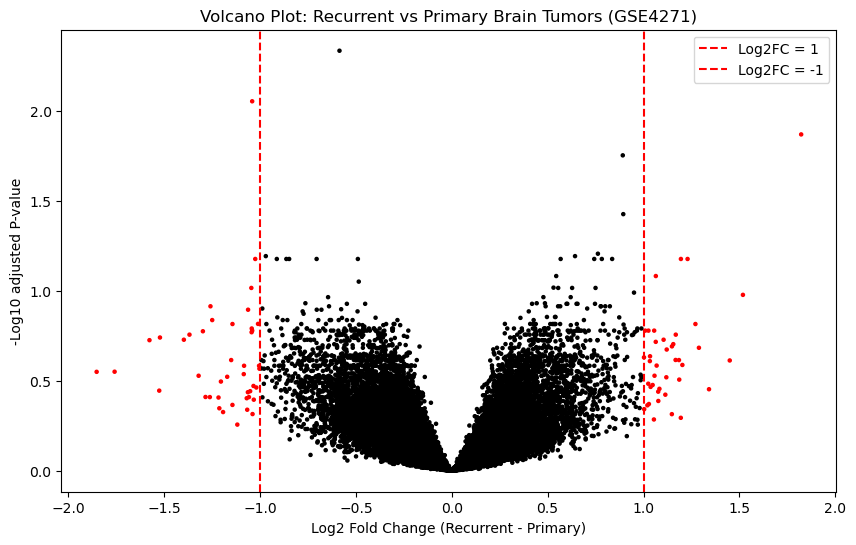

In [ ]:
# Plot volcano plot

colors = np.where(abs(volcano_df["log2FC"]) >= 1, "red", "black")

plt.figure(figsize=(10, 6))
plt.scatter(volcano_df['log2FC'], volcano_df['adj -log10 p-value'], alpha=1, c=colors,s=5)
plt.title('Volcano Plot: Recurrent vs Primary Brain Tumors (GSE4271)')

plt.xlabel('Log2 Fold Change (Recurrent - Primary)')
plt.ylabel('-Log10 (adjusted P-value)')


plt.axvline(x=1, color='red', linestyle='--', label='Log2FC = 1')
plt.axvline(x=-1, color='red', linestyle='--', label='Log2FC = -1')
plt.legend()


